# 109b Final Project: Fake Reviews Detector

*Group Project Members:*

- Geoffrey Humphreys
- Amir Koupaei
- Chris Moon
- Connor Poetzinger

*Due Date: May 8, 2024*

#### Table of Contents

1. [Overview](#overview)
2. [Data Description](#data)
3. [Data Preprocessing](#preprocessing)
4. [Exploratory Data Analysis](#eda)
5. [Modeling](#modeling)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)
8. [Future Work](#future)

## Overview <a class="anchor" id="overview"></a>

This project aims to detect computer generated fake reviews from real reviews. Consumers rely a lot on written reviews and ratings, when purchasing products or services on the internet. However, bad actors have ways to boost ratings with fake reviews - it's a chronic issue in the e-commerce world. 

Given written text and associated ratings from reviews, we deploy NLP techniques to cleanse, preprocess, and model the data. We use a variety of machine learning algorithms, from traditional Scikit-Learn algorithms used in text classification to more modern architectures such SpaCy as transformers, to classify reviews as fake or real.

We begin by loading the data and performing some cleansing techniques to prepare the data for analysis. Exploratory data analysis is performed to understand word frequencies, ratings distributions, and other key features of the data. We then move on to modeling, where we train and test a variety of models to classify reviews as fake or real. We evaluate the models based on accuracy, precision, recall, and F1 score. Finally, we conclude with a summary of our findings and propose future work.

<div id="data"></div>

## Data Set Information and Background

In our group project, we are focusing on the critical task of distinguishing between genuine and counterfeit product reviews leveraging a specially curated dataset designed to mirror the complexities and nuances found in real-world online review platforms. This dataset contains a balanced collection of 40,000 product reviews, equally divided into two distinct categories:
- **Original Reviews**: Genuine product reviews written by real customers.
**Computer-Generated Fake Reviews**: Counterfeit product reviews generated by an algorithm.

Each review in the dataset is annotated according to its source category (OR or GC), enabling us to train and evaluate machine learning models to classify reviews as genuine or counterfeit. The dataset is stored in a CSV file, with each row representing a single review and containing the following columns:
1. `category`: Product category
2. `rating`: Rating of the product
3. `label`: Label indicating whether the review is fake or real
4. `text`: Review text

<div id="preprocessing"></div>

## Data Preprocessing

The data is available in a CSV file named `fake_reviews.csv`. We will load the data into a pandas DataFrame and examine the first few rows to understand the structure of the data.

Our team successfully acquired and prepared our dataset for subsequent analysis. The data was sourced from Kaggle, obtaining a collection of over forty thousand product reviews divided into Original Reviews(OR) and Computer-Generated Fake Reviews(GC). Each review was accompanied by essential features such as product category, rating, label (indicating whether it's genuine or fake), and the review text itself. Upon loading the data into a pandas DataFrame, the first priority was to gain a deep understanding of the structure and content.

Through examination, it was confirmed that the integrity of the dataset was intact, with no missing values, balanced classes, and straightforward data types. The data was then preprocessed to clean the text data, one-hot encode the `category` column, standardize the `rating` column, and label encode the `label` column. These preprocessing steps will be implemented in the subsequent milestone using custom transformers from the `sklearn` library. Custom transformers will allow us to streamline the preprocessing steps and fit into a machine learning pipeline for model training and evaluation.

In [1]:
import copy
import nltk
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import spacy
import time
import warnings

from bs4 import BeautifulSoup
from collections import Counter
from func_timeout import func_timeout, FunctionTimedOut
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
from spacy.training import Example

# from textattack.augmentation import WordNetAugmenter
from textblob import TextBlob

nltk.download("punkt")
nltk.download("stopwords")

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/connorpoetzinger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorpoetzinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("../../data/raw/fake reviews dataset.csv")
df.shape

(40432, 4)

The dataset shape is (40432, 4) and the first few rows are as follows:

In [3]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
df.tail()

,category,rating,label,text_
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...
40431,Clothing_Shoes_and_Jewelry_5,5.0,OR,I work in the wedding industry and have to wor...


In [5]:
df.sample(5)

,category,rating,label,text_
3136,Home_and_Kitchen_5,5.0,OR,We have a couple of ISI whip cream chargers. ...
7150,Sports_and_Outdoors_5,1.0,CG,Adjusted it with the supplied spacer and the c...
5589,Sports_and_Outdoors_5,5.0,OR,"I use this for the beach, it's great. Packs sm..."
26305,Kindle_Store_5,5.0,CG,Sometimes situations in our lives are not alwa...
29173,Books_5,5.0,CG,A find read about a woman who was pregnant and...


By previewing the data, we can see there are reviews for various product categories with a rating between 1 and 5. The `text_` column contains the review text with messy data that will require preprocessing to clean and prepare for analysis. For this type of task (cleaning unstructured text data), we will need to use natural language processing (NLP) techniques to process the text data effectively.

In [6]:
# Check for missing values
df.isna().mean()

category    0.0
rating      0.0
label       0.0
text_       0.0
dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [8]:
df["category"].value_counts()

category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

In [9]:
df["label"].value_counts()

label
CG    20216
OR    20216
Name: count, dtype: int64

In [10]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Lucky for us, the dataset contains no missing values, its classes are balanced, and the data types are easy to work with. We can focus on cleaning the text data and preparing it for analysis. The independent structured data columns (`category`, `rating`) will be useful for exploratory data analysis (EDA) and feature engineering. For modeling, we should consider One Hot encoding the `category` column and standardizing the `rating` column. The dependent variable `label` will be Label Encoded to prepare for classification modeling.

### Preprocessing Steps

Here we define the preprocessing steps necessary for the dataset. SKlearn's custom transformers will be used to implement these steps in the subsequent milestone. The preprocessing steps include:
1. **Text Cleaning**: Remove special characters, punctuation, stopwords, and perform lemmatization. The package `nltk` will be used for this task.
2. **One-Hot Encoding**: Encode the `category` column using one-hot encoding.
3. **Standardization**: Standardize the `rating` column to ensure all features are on the same scale.
4. **Label Encoding**: Encode the `label` column to convert the target variable into numerical format.

In [11]:
# Initialization
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [12]:
class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Using pandarallel for parallel processing
        X_copy[self.column_name] = X_copy[self.column_name].parallel_apply(
            self.clean_text
        )
        return X_copy

    @staticmethod
    def clean_text(text):
        text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
        text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
        text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only alphabets
        text = text.lower()  # Convert to lowercase
        tokens = word_tokenize(text)  # Tokenization
        tokens = [
            word for word in tokens if word.lower() not in stopwords.words("english")
        ]  # Remove stopwords
        return " ".join(tokens)

In [13]:
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
        self.encoder = OneHotEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X[[self.column_name]])
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        encoded = self.encoder.transform(X[[self.column_name]]).toarray()
        for i, category in enumerate(self.encoder.categories_[0]):
            X_copy[category] = encoded[:, i]
        X_copy.drop(columns=[self.column_name], inplace=True)
        return X_copy

In [14]:
class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[[self.column_name]])
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.column_name] = self.scaler.transform(X[[self.column_name]])
        return X_copy

In [15]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
        self.label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.label_encoder.fit(X[self.column_name])
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.column_name] = 1 - self.label_encoder.transform(X[self.column_name])
        return X_copy

In [16]:
def apply_transformations(
    df,
    text_clean=True,
    one_hot_encode=True,
    standardize=True,
    encode_label=True,
    text_column=None,
    category_column=None,
    numerical_column=None,
    label_column=None,
):
    if text_clean and text_column:
        text_cleaner = TextCleanerTransformer(column_name=text_column)
        df = text_cleaner.transform(df)

    if one_hot_encode and category_column:
        one_hot_encoder = OneHotEncoderTransformer(column_name=category_column)
        one_hot_encoder.fit(df)
        df = one_hot_encoder.transform(df)

    if standardize and numerical_column:
        scaler = StandardScalerTransformer(column_name=numerical_column)
        scaler.fit(df)
        df = scaler.transform(df)

    if encode_label and label_column:
        label_encoder = LabelEncoderTransformer(column_name=label_column)
        label_encoder.fit(df)
        df = label_encoder.transform(df)

    return df

In [17]:
# Apply transformations
transformed_df = apply_transformations(
    df,
    text_column="text_",
    category_column="category",
    numerical_column="rating",
    label_column="label",
)

In [18]:
transformed_df.head()

,rating,label,text_,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
0,0.649651,1,love well made sturdy comfortable love itvery ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.649651,1,love great upgrade original ive mine couple years,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.649651,1,pillow saved back love look feel pillow,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.845815,1,missing information use great product price,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.649651,1,nice set good quality set two months,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
transformed_df.to_csv("../../data/processed/processed.csv", index=False)

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In [20]:
raw_df = pd.read_csv("../../data/raw/fake reviews dataset.csv")
processed_df = pd.read_csv("../../data/processed/processed.csv")
processed_df.shape

(40432, 13)

In [21]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   rating                        40432 non-null  float64
 1   label                         40432 non-null  int64  
 2   text_                         40431 non-null  object 
 3   Books_5                       40432 non-null  float64
 4   Clothing_Shoes_and_Jewelry_5  40432 non-null  float64
 5   Electronics_5                 40432 non-null  float64
 6   Home_and_Kitchen_5            40432 non-null  float64
 7   Kindle_Store_5                40432 non-null  float64
 8   Movies_and_TV_5               40432 non-null  float64
 9   Pet_Supplies_5                40432 non-null  float64
 10  Sports_and_Outdoors_5         40432 non-null  float64
 11  Tools_and_Home_Improvement_5  40432 non-null  float64
 12  Toys_and_Games_5              40432 non-null  float64
dtypes

In [22]:
processed_df.describe()

,rating,label,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
count,4.043200e+04,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000
mean,-2.038558e-16,0.500000,0.108083,0.095172,0.098635,0.100317,0.116987,0.088742,0.105214,0.097596,0.095419,0.093837
std,1.000012e+00,0.500006,0.310489,0.293456,0.298175,0.300425,0.321408,0.284374,0.306832,0.296771,0.293797,0.291605
min,-2.845815e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.242157e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.496506e-01,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.496506e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.496506e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Rating Distribution')

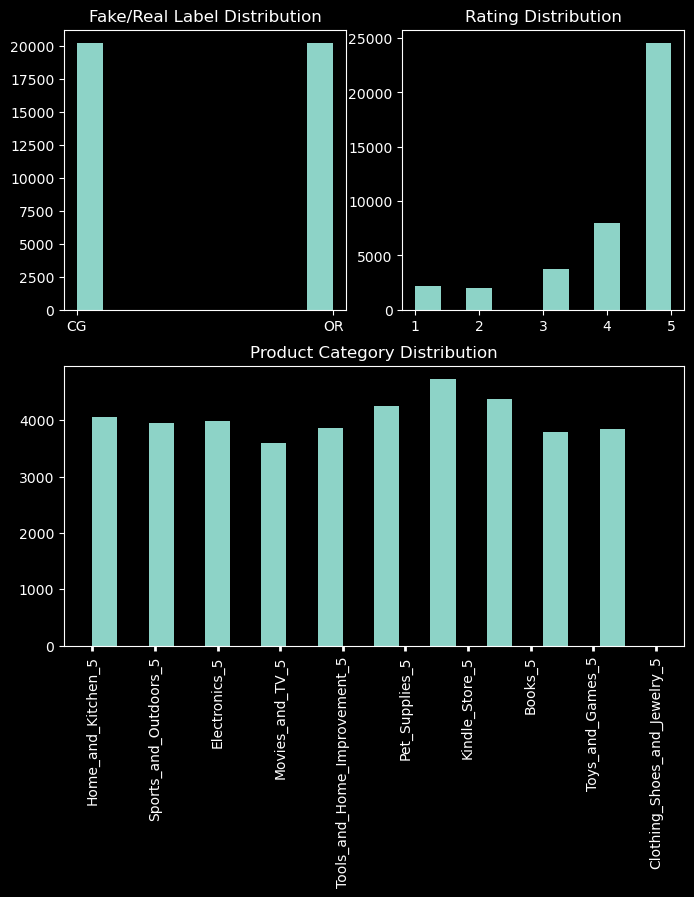

In [23]:
# Histograms
fig = plt.figure(figsize=(8, 8))
spec = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(spec[1, :])
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

ax0.hist(raw_df.category, width=0.4)
ax0.tick_params(axis="x", rotation=90, width=2)
ax0.set_title("Product Category Distribution")

ax1.hist(raw_df.label)
ax1.set_title("Fake/Real Label Distribution")

ax2.hist(raw_df.rating)
ax2.set_title("Rating Distribution")

The histogram labeled "Fake/Real Label Distribution" compares the number of reviews labeled as fake (**CG**) versus real (**OR**). The histogram shows an equal distribution of reviews labeled as fake and real, with each category having 20,000 instances. The equal number of fake and real reviews indicates that there is no class imbalance in the dataset. This balance is advantageous for training machine learning models as it avoids the common issue of bias toward the majority class.

The "Rating Distribution" histogram displays the frequency of reviews across different ratings from 1 to 5. There is a clear skew towards higher ratings, with 5 being the most common rating, followed by a significant but lesser number of 4-star ratings. Ratings of 1, 2, and 3 are much less frequent. The tendency for higher ratings suggests a few possible scenarios: Users generally tend to leave reviews when they have a positive experience, or there could be a presence of incentivized reviews, where reviewers are encouraged to leave positive feedback.

The "Product Category Distribution" histogram shows the count of reviews across various product categories, such as Home and Kitchen, Sports and Outdoors, Electronics, and others. The distribution across categories is relatively even, with slight variations. The even distribution across categories implies that the dataset includes a wide variety of products, which is beneficial for building a general model capable of handling reviews from different categories. It's important to consider whether the product category influences the review's content and sentiment, as this could impact the model's performance.

In [24]:
# Top 20 most common words

# Convert float values to strings before concatenating
all_reviews = " ".join(
    str(review) for review in processed_df["text_"] if isinstance(review, str)
)

# Tokenize the text into individual words
words = all_reviews.split()

# Count the frequency of each word
word_counts = Counter(words)

print("Top 20 most common words:")
for i, (word, count) in enumerate(word_counts.most_common(20), 1):
    print(f"{i}. {word}: {count} times")

Top 20 most common words:
1. great: 16420 times
2. book: 15002 times
3. good: 14200 times
4. one: 13395 times
5. love: 10805 times
6. would: 10362 times
7. well: 10279 times
8. story: 9627 times
9. like: 9428 times
10. read: 8868 times
11. little: 8144 times
12. get: 6467 times
13. recommend: 6179 times
14. characters: 6151 times
15. really: 6119 times
16. use: 5923 times
17. bought: 5736 times
18. also: 5721 times
19. movie: 5548 times
20. im: 5269 times


In [25]:
processed_df.iloc[0:9]["text_"]

0    love well made sturdy comfortable love itvery ...
1    love great upgrade original ive mine couple years
2              pillow saved back love look feel pillow
3          missing information use great product price
4                 nice set good quality set two months
5                             wanted different flavors
6                perfect touch thing wish little space
7    done fit well look great love smoothness edges...
8    great big numbers easy read thing didnt like size
Name: text_, dtype: object

In [26]:
# worst 5, genuine
processed_df[processed_df["label"] == 1][["rating", "label", "text_"]].sort_values(
    by="rating"
).head(5)

,rating,label,text_
40430,-2.845815,1,liked nothing dress reason gave stars ordered ...
22082,-2.845815,1,bought totally happy two us strong dog top nic...
3992,-2.845815,1,kitchen aid went south time try something else...
3990,-2.845815,1,ok product easy use product works mevery prett...
22109,-2.845815,1,listened reviewers quality good really best on...


In [27]:
# worst 5, fake
processed_df[processed_df["label"] == 0][["rating", "label", "text_"]].sort_values(
    by="rating"
).head(5)

,rating,label,text_
14625,-2.845815,0,hyped watch movie theater let movie good decen...
13845,-2.845815,0,boy shags strainge woman woods starts change f...
13844,-2.845815,0,need select different scenes show college clas...
13842,-2.845815,0,satisfied dvd especially sound clear fades sce...
22728,-2.845815,0,even though best value rat pellets price worth...


In [28]:
# best 5, genuine
processed_df[processed_df["label"] == 1][["rating", "label", "text_"]].sort_values(
    by="rating", ascending=False
).head(5)

,rating,label,text_
0,0.649651,1,love well made sturdy comfortable love itvery ...
23277,0.649651,1,package arrived within resonable time frame in...
23233,0.649651,1,third upgrade thought would nice addition litt...
23240,0.649651,1,well made easy clean keep house use go bed thi...
23241,0.649651,1,reluctant buy shipping bit slow however able g...


In [29]:
# best 5, fake
processed_df[processed_df["label"] == 0][["rating", "label", "text_"]].sort_values(
    by="rating", ascending=False
).head(5)

,rating,label,text_
55,0.649651,0,perfect exactly looking
23361,0.649651,0,tried product different cats two gobbled table...
23328,0.649651,0,great product natures miracle jaw scoop helps ...
23329,0.649651,0,oldest cat years gi tract issues occasionally ...
23332,0.649651,0,love harness bigs dogs walk regularly switched...


In the exploration of common words and textual patterns in user reviews, a detailed analysis was conducted to differentiate characteristics of genuine and fake reviews. The findings reveal distinct linguistic and thematic elements that can be leveraged for further modeling and system improvement.

The dataset analysis identified the top 20 most frequently used words in reviews, with prominent terms including "great," "good," "book," "love," and "story." These words suggest a positive sentiment predominantly and indicate a large portion of the dataset might be related to book reviews or other entertainment-related products, given the frequent mentions of "book" and "story."

Delving deeper into the nature of the reviews, especially when segregating the worst and best reviews for both genuine and fake categories, several critical differences emerge:

- Genuine reviews that were rated poorly typically contained explicit expressions of dissatisfaction, often mentioning specific issues related to product functionality, quality, or mismatched expectations. For instance, genuine negative reviews detailed problems with products and provided reasons for their ratings, indicating a clear relationship between the product experience and the review content.
- In contrast, the worst fake reviews often lacked detail and relevance, with vague and sometimes irrelevant content, suggesting that these reviews did not stem from actual product use or genuine user experiences.
Similarly, the best reviews in the genuine category were rich in detail, discussing product benefits, usability, and often exceeding expectations. They typically elaborated on how the product was used, its durability, and satisfaction with its performance, indicating an authentic user engagement with the product.

Conversely, the best fake reviews, while positive, displayed suspicious patterns of brevity and lacked the specificity seen in genuine reviews. These reviews often contained generic praise and were short, missing personal experience details that typically accompany a genuine review.

From these observations, it is evident that textual analysis and sentiment examination can significantly contribute to distinguishing between genuine and fake reviews. The patterns observed suggest that fake reviews are often either overly positive without specific details or negative with irrelevant content.

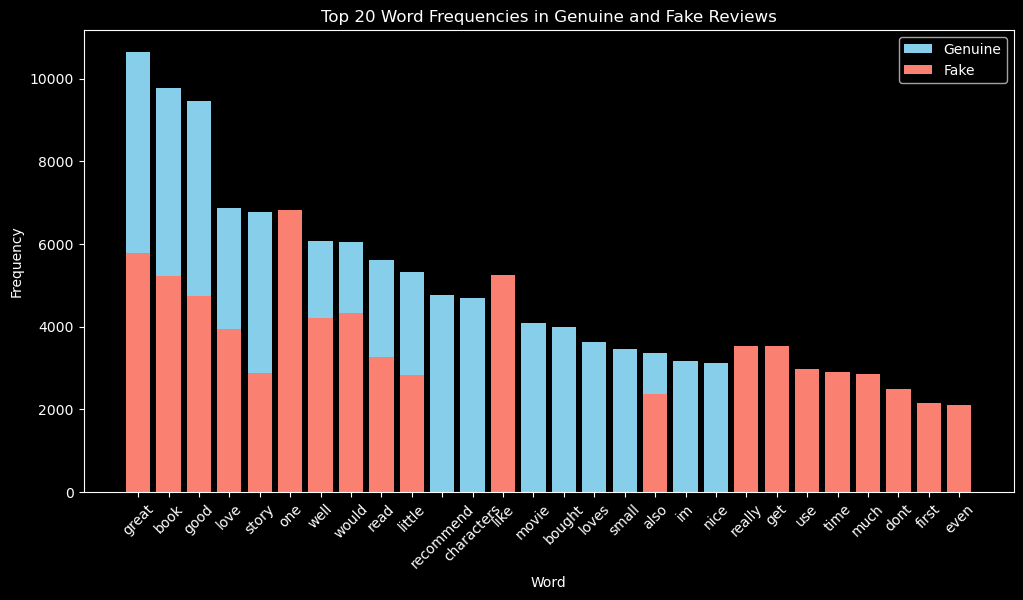

In [30]:
# Tokenize function
def tokenize(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []


# Separate genuine and fake reviews
genuine_reviews = processed_df[processed_df["label"] == 1]["text_"]
fake_reviews = processed_df[processed_df["label"] == 0]["text_"]

# Tokenize genuine reviews
genuine_tokens = genuine_reviews.apply(tokenize)

# Tokenize fake reviews
fake_tokens = fake_reviews.apply(tokenize)

# Flatten the list of tokens
genuine_words = [word for sublist in genuine_tokens for word in sublist]
fake_words = [word for sublist in fake_tokens for word in sublist]

# Count word frequency for genuine reviews
genuine_word_freq = Counter(genuine_words)

# Count word frequency for fake reviews
fake_word_freq = Counter(fake_words)

# Plot word frequency distributions
plt.figure(figsize=(12, 6))
plt.bar(*zip(*genuine_word_freq.most_common(20)), color="skyblue", label="Genuine")
plt.bar(*zip(*fake_word_freq.most_common(20)), color="salmon", label="Fake")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 20 Word Frequencies in Genuine and Fake Reviews")
plt.xticks(rotation=45)
plt.legend()
plt.show()

The bar chart presents a comparative analysis of the top 20 word frequencies in genuine and fake reviews, offering insights into the linguistic patterns that distinguish authentic submissions from manipulated ones. This comparison reveals that positive adjectives like "great," "good," and "nice" are prevalent in both types of reviews, with "great" appearing more frequently in fake reviews, suggesting a possible overuse to project overly positive sentiment and influence buyer behavior. Words specific to products, such as "book" and "movie," indicate the categories most discussed, with "book" showing a notably higher frequency in genuine reviews, reflecting more authentic engagement.

Transactional words like "bought" feature prominently in both genuine and fake reviews, nearly matching in frequency, which underscores that mere mention of a purchase does not necessarily confirm a review's authenticity. Words that imply a recommendation, such as "recommend," appear more in genuine reviews, likely indicating real endorsements based on user satisfaction. Conversely, the lesser frequency of these words in fake reviews might point to a lack of genuine recommendation intent.

Detail-oriented words like "story" and "characters" are used more in genuine reviews, suggesting a deeper engagement with the content and a more thoughtful critique, which are hallmarks of authenticity. This nuanced analysis of word usage highlights several important factors for distinguishing genuine reviews from fake ones. Overrepresentation of positive adjectives in reviews could be a red flag for inauthenticity, especially if they are not supported by detailed explanations. Words that suggest detailed product engagement are more convincing as indicators of authenticity, whereas the equal use of transactional language across review types suggests that stating a purchase alone does not verify the authenticity of a review.

These findings can assist businesses in refining algorithms designed to detect fake reviews by focusing on the balance and context of word usage, not just frequency. Enhancing the authenticity checks of reviews is crucial for maintaining the integrity of e-commerce platforms and ensuring consumer trust, as it directly impacts the reliability of customer feedback.

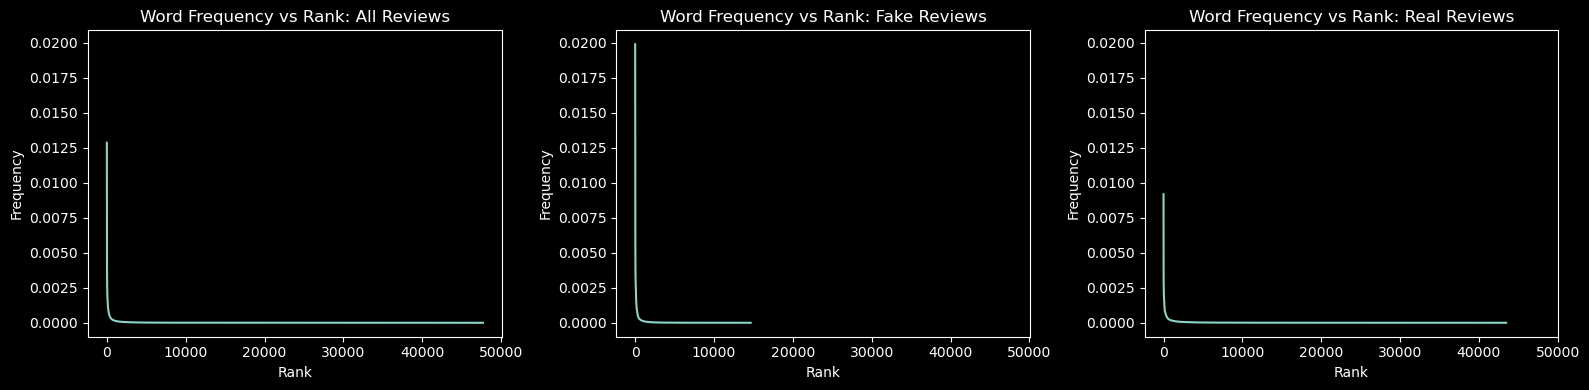

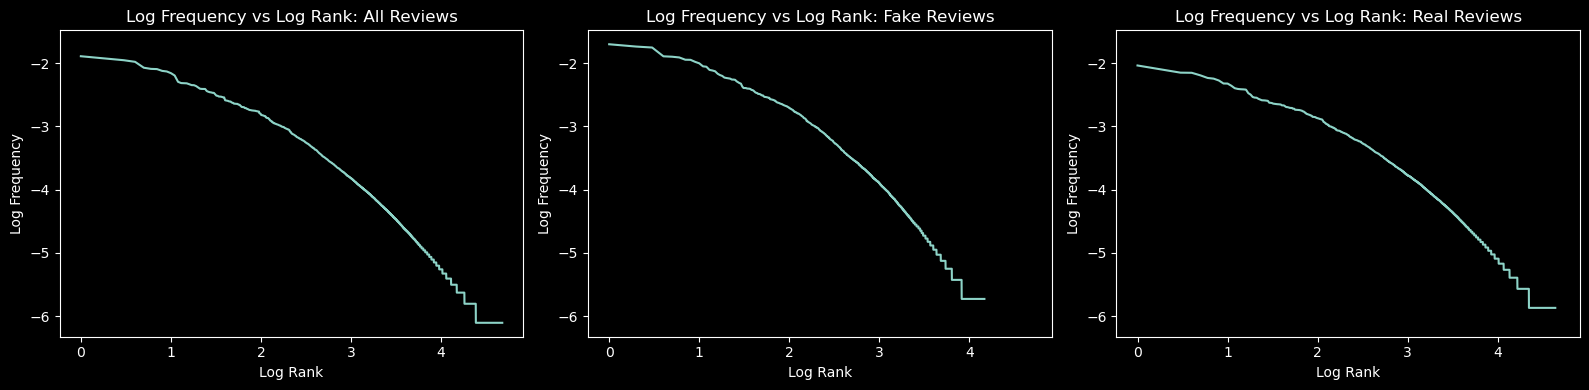

In [31]:
# Generate plots of word frequency vs. rank

all_words = []
cg_words = []
or_words = []


for i in processed_df.index:
    s = processed_df.loc[i, "text_"]
    if s == np.nan:
        continue
    words = str(s).split(" ")
    if processed_df.loc[i, "label"] == 1:
        for w in words:
            all_words.append(w)
            cg_words.append(w)
    else:
        for w in words:
            all_words.append(w)
            or_words.append(w)

word_counts = pd.Series(all_words).value_counts()
cg_word_counts = pd.Series(cg_words).value_counts()
or_word_counts = pd.Series(or_words).value_counts()

nwords = word_counts.shape[0]
cg_nwords = cg_word_counts.shape[0]
or_nwords = or_word_counts.shape[0]

xmin = word_counts.shape[0] * -0.05
xmax = word_counts.shape[0] * 1.05
yl = max(
    max(word_counts) / word_counts.sum(),
    max(cg_word_counts) / cg_word_counts.sum(),
    max(or_word_counts) / or_word_counts.sum(),
)
ymax = yl * 1.05
ymin = yl * -0.05

fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

axs[0].plot(range(1, nwords + 1), word_counts / word_counts.sum())
axs[0].set_title("Word Frequency vs Rank: All Reviews")
axs[0].set_xlabel("Rank")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim((xmin, xmax))
axs[0].set_ylim((ymin, ymax))

axs[1].plot(range(1, cg_nwords + 1), cg_word_counts / cg_word_counts.sum())
axs[1].set_title("Word Frequency vs Rank: Fake Reviews")
axs[1].set_xlabel("Rank")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim((xmin, xmax))
axs[1].set_ylim((ymin, ymax))

axs[2].plot(range(1, or_nwords + 1), or_word_counts / or_word_counts.sum())
axs[2].set_title("Word Frequency vs Rank: Real Reviews")
axs[2].set_xlabel("Rank")
axs[2].set_ylabel("Frequency")
axs[2].set_xlim((xmin, xmax))
axs[2].set_ylim((ymin, ymax))

plt.tight_layout()

fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

xmin = np.log(word_counts.shape[0]) / np.log(10) * -0.05
xmax = np.log(word_counts.shape[0]) / np.log(10) * 1.05
ymax = max(np.log(word_counts) / np.log(10)) * 1.05
ymin = max(np.log(word_counts) / np.log(10)) * -0.05

ymx = np.log(
    max(
        word_counts.max() / word_counts.sum(),
        cg_word_counts.max() / cg_word_counts.sum(),
        or_word_counts.max() / or_word_counts.sum(),
    )
) / np.log(10)
ymn = np.log(
    min(
        word_counts.min() / word_counts.sum(),
        cg_word_counts.min() / cg_word_counts.sum(),
        or_word_counts.min() / or_word_counts.sum(),
    )
) / np.log(10)

yd = ymx - ymn

ymax = ymx + yd * 0.05
ymin = ymn - yd * 0.05


axs[0].plot(
    np.log(range(1, nwords + 1)) / np.log(10),
    np.log(word_counts / word_counts.sum()) / np.log(10),
)
axs[0].set_title("Log Frequency vs Log Rank: All Reviews")
axs[0].set_xlabel("Log Rank")
axs[0].set_ylabel("Log Frequency")
axs[0].set_xlim((xmin, xmax))
axs[0].set_ylim((ymin, ymax))


axs[1].plot(
    np.log(range(1, cg_nwords + 1)) / np.log(10),
    np.log(cg_word_counts / cg_word_counts.sum()) / np.log(10),
)
axs[1].set_title("Log Frequency vs Log Rank: Fake Reviews")
axs[1].set_xlabel("Log Rank")
axs[1].set_ylabel("Log Frequency")
axs[1].set_xlim((xmin, xmax))
axs[1].set_ylim((ymin, ymax))

axs[2].plot(
    np.log(range(1, or_nwords + 1)) / np.log(10),
    np.log(or_word_counts / or_word_counts.sum()) / np.log(10),
)
axs[2].set_title("Log Frequency vs Log Rank: Real Reviews")
axs[2].set_xlabel("Log Rank")
axs[2].set_ylabel("Log Frequency")
axs[2].set_xlim((xmin, xmax))
axs[2].set_ylim((ymin, ymax))

plt.tight_layout()

In analyzing the word frequency versus rank across all reviews, both genuine and fake, the investigation prominently employs linear and logarithmic scale graphs. This approach aims to determine whether the distribution of word usage adheres to Zipf's Law, which states that in a naturally occurring corpus of text, the frequency of any word is inversely proportional to its rank. According to Zipf's Law, the most frequent word appears roughly twice as often as the second most frequent word, three times as often as the third, and so on, resulting in a linear relationship when plotted on a log-log graph.

Upon reviewing the linear scale plots, a typical rapid decline in frequency after the initial few ranks is evident, aligning with the expected behavior of linguistic distributions. In the logarithmic scale analysis, which is more diagnostic for examining Zipf's Law, the data shows a near-linear relationship between log frequency and log rank for the bulk of the data points. This observation corroborates that the general word frequency distribution in the review texts follows Zipf's Law to a significant extent.

However, notable deviations occur, particularly in the tail regions of these distributions. The tails show curvature and divergence from the expected linear trend, suggesting anomalies in the less frequent words. These deviations are particularly insightful because they might indicate the presence of manipulation within the fake reviews. Unlike genuine reviews, which draw from a broad and diverse vocabulary reflective of varied and authentic user experiences, the fake reviews seem to exhibit restricted vocabulary usage. This constrained range suggests that the creators of fake reviews may rely on a limited set of terms that are repeatedly used to mimic positive or negative sentiments, thereby not following the natural distribution predicted by Zipf's Law. This pattern of deviation, especially in the tail regions, highlights the artificial nature of the language used in fake reviews and underscores the potential manipulation of review content to influence perceptions or achieve specific outcomes.

## Model Development <a class="anchor" id="modeling"></a>

### Traditional Machine Learning Models

In developing a model to detect fake reviews, one avenue we chose to explore was an approach that emphasizes statistical and qualitative linguistic features over deep learning-based natural language processing (NLP) transformers. This decision was based on several key considerations grounded in both practicality and literature on text analysis. In particular, M.L. Newman's 2003 paper "Lying words: Predicting deception from linguistic styles" identifies key linguistic cues that are often present in deceptive text. These cues include the use of fewer first-person pronouns, more negative emotion words, and fewer unique words.

The preprocessing steps where taken care of in a previous milestone, where we cleaned the text data, removed stopwords, and tokenized the text. In this milestone, we focus on feature engineering to extract relevant statistical and  qualitative aspects of the text that are indicative of authenticity or deception. By focusing on elements such as sentiment analysis, unique word counts, and POS tagging, we align our methodology with literature findings that suggests these metrics can effectively distinguish genuine content from fake reviews.

**Feature Justification:**
- **Sentiment Analysis:** Sentiment analysis is a common feature used in fake review detection models. Fake reviews often exhibit extreme sentiment, either overly positive or negative, as a way to manipulate readers' perceptions. By calculating sentiment scores for each review, we can identify reviews with sentiment that deviates significantly from the norm.
- **Unique Word Count:** Fake reviews often contain fewer unique words compared to genuine reviews. This is because deceptive text tends to be more repetitive and less detailed. By counting the number of unique words in each review, we can capture this characteristic.
- **Parts of Speech (POS) Tagging:** POS tagging can provide insights into the syntactic structure of the text. Deceptive reviews may exhibit different POS patterns compared to genuine reviews. For example, fake reviews might contain more adjectives or nouns to create a positive or negative impression without providing substantive information. By analyzing the distribution of POS tags in the text, we can identify patterns that are indicative of deception.

The choice to utilize machine learning models like AdaBoost, Random Forest, and Logistic Regression was motivated by their interpretability, ease of implementation, and ability to handle a mix of numerical and categorical features. These models are well-suited for the linguistic features we have engineered, as they can capture complex relationships between the features and the target variable (fake vs. genuine reviews).

**Modeling with Selected Features:**
- **AdaBoost:** AdaBoost is an ensemble method that combines multiple weak learners to create a strong classifier. It is particularly effective when dealing with text data and can handle both numerical and categorical features. By using AdaBoost, we aim to leverage the power of boosting to improve the model's performance.
- **Random Forest:** Random Forest is an ensemble method that builds multiple decision trees and combines their predictions. It is robust to overfitting and can handle a mix of feature types. Random Forest is well-suited for our linguistic features as it can capture non-linear relationships between the features and the target variable.
- **Logistic Regression:** Logistic Regression is a linear model that is widely used for binary classification tasks. It is interpretable and can provide insights into the importance of each feature. By using Logistic Regression, we aim to understand the contribution of each linguistic feature to the model's predictions.

In [32]:
def load_data(filepath="../../data/processed/processed.csv"):
    return pd.read_csv(filepath)


def generate_sentiment_scores(df):
    sentiments = df["text_"].apply(lambda review: TextBlob(str(review)).sentiment)
    df["sentiment_score"], df["sentiment_subjectivity"] = zip(*sentiments)
    return df


def visualize_sentiment_scores(df):
    sns.histplot(df["sentiment_score"], kde=True)
    plt.title("Sentiment Score Distribution")
    plt.show()

    sentiment_categories = df["sentiment_score"].apply(
        lambda score: "Positive" if score >= 0 else "Negative"
    )
    sns.countplot(x=sentiment_categories)
    plt.title("Sentiment Score Distribution")
    plt.show()


def count_negative_words(df):
    df["neg_count"] = df["text_"].apply(
        lambda review: sum(
            TextBlob(word).sentiment.polarity < 0 for word in str(review).split()
        )
    )
    return df


def count_unique_words(df):
    df["word_count"] = df["text_"].apply(lambda x: len(str(x).split()))
    df = df[df["word_count"] != 0].reset_index(drop=True)
    df["unique_word_count"] = df["text_"].apply(lambda x: len(set(str(x).split())))
    return df


# pos tagging
articles = ["a", "an", "the"]
negations = [
    "not",
    "no",
    "never",
    "none",
    "nobody",
    "nothing",
    "neither",
    "nowhere",
    "nor",
]
auxiliaries = [
    "be",
    "have",
    "do",
    "will",
    "would",
    "shall",
    "should",
    "can",
    "could",
    "may",
    "might",
    "must",
]


def count_pos(review):
    filter = re.sub("[^\w\s]", "", str(review))
    review_lower = filter.lower()
    review_split = review_lower.split()

    unique_words = Counter(review_split)
    sentence = " ".join(unique_words.keys())

    word_list = nltk.word_tokenize(sentence)

    Art = sum(word in articles for word in word_list)
    Nega = sum(word in negations for word in word_list)
    Aux = sum(word in auxiliaries for word in word_list)

    tagged = nltk.pos_tag(word_list)
    counts = Counter(tag for word, tag in tagged)

    nount_count = sum(counts[i] for i in counts.keys() if "NN" in i)
    verb_count = sum(counts[i] for i in counts.keys() if "VB" in i)
    adj_count = sum(counts[i] for i in counts.keys() if "JJ" in i)
    adv_count = sum(counts[i] for i in counts.keys() if "RB" in i)
    pro_count = sum(
        counts[i]
        for i in counts.keys()
        if (("PRP" in i) or ("PRP$" in i) or ("WP" in i) or ("WP$" in i))
    )
    pre_count = sum(counts[i] for i in counts.keys() if "IN" in i)
    con_count = sum(counts[i] for i in counts.keys() if "CC" in i)

    return [
        nount_count,
        verb_count,
        adj_count,
        adv_count,
        pro_count,
        pre_count,
        con_count,
        Art,
        Nega,
        Aux,
    ]


def calculate_authenticity(df):
    df["authenticity"] = (
        df["pro_count"] + df["unique_word_count"] - df["neg_count"]
    ) / df["word_count"]
    return df


def calculate_analytical_thinking(df):
    df["analytical_thinking"] = (
        30
        + df[["art_count", "pre_count"]].sum(axis=1)
        - df[["pro_count", "con_count", "adv_count", "neg_count"]].sum(axis=1)
    )
    return df


def create_pipeline(estimator, param_grid, cv):
    pipeline = Pipeline(
        [
            ("preprocessing", MinMaxScaler()),
            (
                "classifier",
                GridSearchCV(
                    estimator=estimator,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    cv=cv,
                    n_jobs=-1,
                ),
            ),
        ]
    )
    return pipeline


def fit_pipeline(pipeline, X_train, y_train):
    print("Fitting grid search...")
    pipeline.fit(X_train, y_train)
    print("Grid search fitted.")
    return pipeline


def evaluate_models(models, X, y, folds):
    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "f1_score": make_scorer(f1_score),
    }
    scores = {
        model_name: cross_validate(model, X, y, cv=folds, scoring=scoring)
        for model_name, model in models.items()
    }
    models_scores_table = pd.DataFrame(
        {
            model_name: [
                model_scores["test_accuracy"].mean(),
                model_scores["test_precision"].mean(),
                model_scores["test_recall"].mean(),
                model_scores["test_f1_score"].mean(),
            ]
            for model_name, model_scores in scores.items()
        },
        index=["Accuracy", "Precision", "Recall", "F1 Score"],
    )
    models_scores_table["Best Score"] = models_scores_table.idxmax(axis=1)
    return models_scores_table

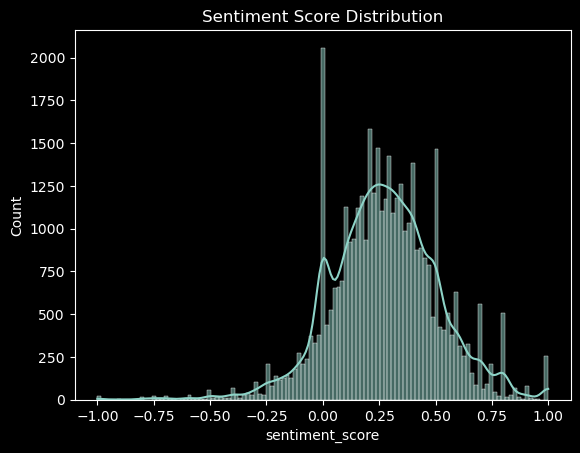

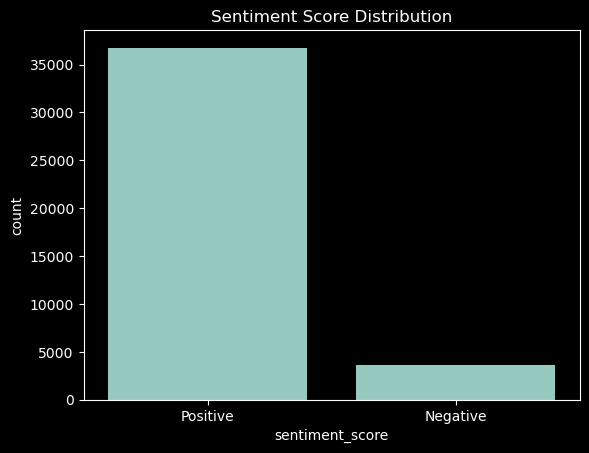

In [33]:
df = load_data()
df = generate_sentiment_scores(df)
visualize_sentiment_scores(df)
df = count_negative_words(df)
df = count_unique_words(df)
pos = [
    "noun_count",
    "verb_count",
    "adj_count",
    "adv_count",
    "pro_count",
    "pre_count",
    "con_count",
    "art_count",
    "neg_count",
    "aux_count",
]
df[pos] = (
    pd.DataFrame(df["text_"].apply(count_pos).tolist(), columns=pos)
    .fillna(0)
    .astype(int)
)
df = calculate_authenticity(df)
df = calculate_analytical_thinking(df)

The sentiment analysis visualizations provided offer a nuanced understanding of the emotional tone within the dataset of reviews. The first plot, showcasing a distribution of sentiment scores, is critical for identifying how sentiments are spread across the review corpus. This histogram, presenting a bell-shaped curve, indicates that most reviews cluster around a neutral sentiment score, with fewer reviews exhibiting extreme positive or negative sentiments. This could suggest that while extreme sentiments are present, they are not the norm and could be indicative of outliers or anomalies in sentiment expression, possibly associated with fake reviews.

The second plot simplifies the sentiment distribution into two broad categories: positive and negative. The stark contrast in the number of positive versus negative reviews is immediately apparent, with positive sentiments overwhelmingly dominating. This could indicate a tendency for reviews, whether genuine or fake, to skew towards positive expressions. This is particularly relevant for detecting fake reviews, as it's common for such reviews to employ overly positive sentiments to influence perceptions or to mask their deceptive nature.

From a modeling perspective, these sentiment distributions provide a foundational understanding of how sentiment could be leveraged as a predictive feature. Given that fake reviews might either be extremely positive to seem overly enthusiastic or negative if aimed at damaging a competitor, identifying reviews with sentiment scores that deviate significantly from the central tendency could be a strategy for isolating potential fakes.

In [34]:
df_model = df[
    [
        "rating",
        "sentiment_score",
        "sentiment_subjectivity",
        "word_count",
        "noun_count",
        "adj_count",
        "verb_count",
        "adv_count",
        "authenticity",
        "analytical_thinking",
        #        "score",
    ]
]

X = df_model
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
# Adaboost
DTC = DecisionTreeClassifier(random_state=11, class_weight="balanced", max_depth=None)
ABC = AdaBoostClassifier(estimator=DTC)
parameters = {
    "n_estimators": [2, 8, 12, 20],
    "learning_rate": [(0.97 + x / 100) for x in range(0, 8)],
    "algorithm": ["SAMME"],
}
pipeline1 = create_pipeline(ABC, parameters, 5)
pipeline1 = fit_pipeline(pipeline1, X_train, y_train)

# RandomForest
parameters = {
    "bootstrap": [True],
    "max_depth": [3, 15, 63],
    "max_features": [2, 6, 9],
    "min_samples_leaf": [1, 3, 5],
    "min_samples_split": [2, 7, 11],
    "n_estimators": [30, 100, 300],
}
pipeline2 = create_pipeline(
    RandomForestClassifier(random_state=42), parameters, StratifiedKFold(n_splits=2)
)
pipeline2 = fit_pipeline(pipeline2, X_train, y_train)

# Logistic Regression
parameters = {
    "C": [10**i for i in range(-5, 5)],
    "class_weight": [None, "balanced"],
}
pipeline3 = create_pipeline(
    LogisticRegression(max_iter=100), parameters, StratifiedKFold(n_splits=5)
)
pipeline3 = fit_pipeline(pipeline3, X_train, y_train)

models = {
    "AdaBoost": pipeline1,
    "Random Forest": pipeline2,
    "Logistic Regression": pipeline3,
}

models_scores_table = evaluate_models(models, X, y, 3)

Fitting grid search...
Grid search fitted.
Fitting grid search...
Grid search fitted.
Fitting grid search...


/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Grid search fitted.


/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [36]:
models_scores_table

,AdaBoost,Random Forest,Logistic Regression,Best Score
Accuracy,0.675703,0.729596,0.697814,Random Forest
Precision,0.676258,0.721248,0.695524,Random Forest
Recall,0.674665,0.749606,0.704442,Random Forest
F1 Score,0.675385,0.734936,0.699916,Random Forest


The training and evaluation of three machine learning models—AdaBoost, Random Forest, and Logistic Regression—were implemented to address the challenge of detecting fake reviews. Each model was configured with specific parameters to optimize their performance for this task. AdaBoost utilized a Decision Tree Classifier, emphasizing a strategy with balanced class weights and allowing the trees to grow without constraints. This setup, combined with an exploration of varying numbers of estimators and learning rates, was intended to robustly adjust to classification errors. The Random Forest model, on the other hand, was fine-tuned through an extensive range of hyperparameters, including maximum depth, maximum features, and the number of trees, aiming to strike a balance between reducing overfitting and maintaining the ability to capture complex patterns in the data. Logistic Regression was tested across a wide spectrum of regularization strengths and class weighting options, facilitating a detailed examination of its predictive nuances.

Upon evaluation, Random Forest emerged as the superior model across all key metrics: accuracy, precision, recall, and F1 score, highlighting its effectiveness in the binary classification of reviews as fake or genuine. Notably, it achieved the highest accuracy at approximately 72.96%, the best precision at around 72.12%, and an outstanding recall of about 74.96%, which underscores its capability to identify a high proportion of actual positive instances (fake reviews) effectively. These results suggest that Random Forest's ensemble approach, which leverages multiple decision trees to reduce variance and bias, is particularly well-suited for datasets typical of consumer reviews.

### SpaCy Transformer Models

In the next phase of our modeling efforts, we will explore the capabilities of spaCy's transformer models, which leverage the cutting-edge advancements in deep learning for natural language processing. SpaCy's transformer models are built on architectures like BERT and RoBERTa, designed to capture a deeper understanding of language context and semantics. These models excel in extracting meaningful patterns from complex text data, making them highly effective for tasks that involve understanding nuances in text such as sentiment analysis, entity recognition, and, pertinent to our case, detecting fake reviews. By incorporating these powerful models, we aim to enhance our detection system's accuracy and sensitivity, providing a more robust solution for identifying deceptive review content. This approach will enable us to tap into the more subtle linguistic cues that may indicate falseness in reviews, potentially offering superior performance over traditional machine learning methods.

In [38]:
nlp = spacy.load("en_core_web_sm")
# show architecture
for pipe in nlp.pipe_names:
    print(nlp.get_pipe_config(pipe))

{'factory': 'tok2vec', 'model': {'@architectures': 'spacy.Tok2Vec.v2', 'embed': {'@architectures': 'spacy.MultiHashEmbed.v2', 'width': '${components.tok2vec.model.encode:width}', 'attrs': ['NORM', 'PREFIX', 'SUFFIX', 'SHAPE', 'SPACY', 'IS_SPACE'], 'rows': [5000, 1000, 2500, 2500, 50, 50], 'include_static_vectors': False}, 'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2', 'width': 96, 'depth': 4, 'window_size': 1, 'maxout_pieces': 3}}}
{'factory': 'tagger', 'label_smoothing': 0.0, 'model': {'@architectures': 'spacy.Tagger.v2', 'nO': None, 'normalize': False, 'tok2vec': {'@architectures': 'spacy.Tok2VecListener.v1', 'width': '${components.tok2vec.model.encode:width}', 'upstream': 'tok2vec'}}, 'neg_prefix': '!', 'overwrite': False, 'scorer': {'@scorers': 'spacy.tagger_scorer.v1'}}
{'factory': 'parser', 'learn_tokens': False, 'min_action_freq': 30, 'model': {'@architectures': 'spacy.TransitionBasedParser.v2', 'state_type': 'parser', 'extra_state_tokens': False, 'hidden_width': 6

<p style="color:red">Explain Model Architecture</p>

In [39]:
processed_df = load_data("../../data/processed/processed.csv")
product_categories = processed_df.columns[3:]

In [40]:
X = processed_df.iloc[:, 2:].values
y = processed_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
def generate_spacy_train_examples(X, y, prod_cat_index=-1):
    train_examples = []

    if prod_cat_index == -1:
        text_label_pairs = np.transpose(np.vstack((X[:, 0], y)))
    else:
        row_indices = np.where(X[:, prod_cat_index + 1] == 1)
        text_label_pairs = np.transpose(np.vstack((X[row_indices, 0], y[row_indices])))

    for text_label in text_label_pairs:
        label = {"spam": bool(text_label[1]), "ham": (not bool(text_label[1]))}
        train_examples.append(
            Example.from_dict(nlp.make_doc(str(text_label[0])), {"cats": label})
        )
    print(f"Generating {len(train_examples)} train examples for the spaCy model...")
    return train_examples

In [42]:
nlp = spacy.load("en_core_web_sm")

config = {"threshold": 0.5, "model": DEFAULT_MULTI_TEXTCAT_MODEL}

textcat = nlp.add_pipe("textcat", config=config)
textcat.add_label("spam")
textcat.add_label("ham")

train_examples = generate_spacy_train_examples(X_train, y_train)
textcat.initialize(lambda: train_examples, nlp=nlp)

Generating 32345 train examples for the spaCy model...


In [43]:
epochs = 2
with nlp.select_pipes(enable="textcat"):
    optimizer = nlp.resume_training()
    for i in range(epochs):
        random.shuffle(train_examples)
        for example in train_examples:
            nlp.update([example], sgd=optimizer)

In [44]:
def find_model_accuracy(X, y, spacy_nlp, prod_cat_index=-1):
    if prod_cat_index == -1:
        X_test = X[:, 0]
        y_test = y
    else:
        row_indices = np.where(X[:, prod_cat_index + 1] == 1)
        X_test = X[row_indices, 0][0]
        y_test = y[row_indices]
    y_pred = []
    for test_sample in X_test:
        testdoc = spacy_nlp(str(test_sample))
        y_pred.append(testdoc.cats["spam"] > 0.5)
    y_pred = np.array(y_pred).astype(int)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [45]:
overall_accuracy = find_model_accuracy(X_test, y_test, nlp)
accuracy_list = []
for idx, category in enumerate(product_categories):
    accuracy_list.append(find_model_accuracy(X_test, y_test, nlp, idx))

In [46]:
print("The test accuracy scores for each product category are:")
for cat, acc in zip(product_categories, accuracy_list):
    print(f"{cat.replace('_',' ').replace('5','').ljust(30)}:\t{acc:.2f}")

print(f"\nThe overall accuracy of the base model is {overall_accuracy:.2f}.")

The test accuracy scores for each product category are:
Books                         :	0.90
Clothing Shoes and Jewelry    :	0.88
Electronics                   :	0.91
Home and Kitchen              :	0.91
Kindle Store                  :	0.89
Movies and TV                 :	0.89
Pet Supplies                  :	0.89
Sports and Outdoors           :	0.91
Tools and Home Improvement    :	0.91
Toys and Games                :	0.91

The overall accuracy of the base model is 0.90.


#### An Adversarial Approach to Fake Review Detection

<!-- <p style="color:red">Cannot run this portion. Having a hard time with textattack package not working with my current environment.</p> -->

In the following section, we explore the resilience of our model against sophisticated spam tactics commonly employed by spammers to manipulate or evade detection systems. This involves the creation of an augmented dataset that simulates potential manipulative strategies, such as synonym substitution, to represent the various tricks that spammers might deploy. Specifically, the section details our methodology for enhancing the dataset by incorporating 40% synonym swaps into the original reviews. This approach helps in simulating a more challenging environment for the model, testing its capability to detect spam under altered linguistic conditions.

The process starts with the standard cleaning of text data to remove HTML tags, URLs, and non-alphabetic characters, and then proceeds to lowercasing and tokenization, stripping away stopwords to focus on significant content. The model training utilizes spaCy’s en_core_web_sm model equipped with a multi-label text categorization component, adjusted for a balanced threshold setting. By integrating both original and synonym-augmented texts into the training set, we prepare the model to recognize spam even when the review content is subtly altered.

The core of this section is the rigorous training and evaluation of the model with this augmented data, aiming to robustly prepare it against an array of adversarial attacks, particularly "thesaurus attacks" where spammers might replace words with their synonyms to evade detection. The model’s performance is quantitatively assessed by modifying the percentage of substituted words and observing the corresponding changes in accuracy. This empirical approach not only tests the model's effectiveness under stress but also highlights potential areas for further refinement to enhance its detection accuracy.

In [47]:
raw_text = raw_df["text_"].tolist()


def clean_text(text):
    if isinstance(text, float):
        text = ""
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only alphabets
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenization
    tokens = [
        word for word in tokens if word.lower() not in stopwords.words("english")
    ]  # Remove stopwords
    if len(tokens) == 0:
        return ""
    else:
        return " ".join(tokens)


def get_augmented(pct=0.2):
    p = str(int(pct * 100))
    p = re.sub("0*$", "", p)
    fn = "../../data/df_p" + p + ".csv"
    df = pd.read_csv(fn, index_col=0)
    return (df["0"]).tolist()


def to_shingles(s, l=10):
    a = re.sub("[^A-Za-z0-9_]+", " ", s).lower().strip().split(" ")
    rv = []
    for i in range(0, int((len(a) + (l - 1)) / l)):
        lo = i * l
        hi = lo + l if lo + l <= len(a) else len(a)
        rv = rv + [" ".join(a[lo:hi])]
    return rv

In [48]:
# The aim is to generate an augmented dataset that is representative of the sorts of tricks that spammers might try.
# We will use the original dataset concatenated with a copy that has 40% of the words swapped with synonyms.
# Note that we will be training the model with augmented data indicating that human-generated reviews with swapped-out words are not computer-generated!
try:
    raw_df = pd.read_csv("data/raw/fake reviews dataset.csv")
    processed_df = pd.read_csv("data/processed/processed.csv")
except:
    raw_df = pd.read_csv("../../data/raw/fake reviews dataset.csv")
    processed_df = pd.read_csv("../../data/processed/processed.csv")

X = processed_df.text_.values
y = processed_df.label.values
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(
    X, y, np.arange(0, X.shape[0]), test_size=0.2
)


X_aug = pd.Series(list(map(clean_text, get_augmented(0.4))))

nlp_aug = spacy.load("en_core_web_sm")

config = {"threshold": 0.5, "model": DEFAULT_MULTI_TEXTCAT_MODEL}

textcat_aug = nlp_aug.add_pipe("textcat", config=config)
aug_train_examples = []
for idx, text in enumerate(X_aug[ix_train]):
    label = {"spam": bool(y_train[idx]), "ham": (not bool(y_train[idx]))}
    aug_train_examples.append(
        Example.from_dict(nlp.make_doc(str(text)), {"cats": label})
    )

for idx, text in enumerate(X_train):
    label = {"spam": bool(y_train[idx]), "ham": (not bool(y_train[idx]))}
    aug_train_examples.append(
        Example.from_dict(nlp.make_doc(str(text)), {"cats": label})
    )

textcat_aug.add_label("spam")
textcat_aug.add_label("ham")
textcat_aug.initialize(lambda: aug_train_examples, nlp=nlp_aug)

In [49]:
# Train a model with the augmented training data


def get_aug_error(p, model, name="base"):
    aug_test = copy.copy(X_test)
    if p > 0:
        aug = pd.Series(get_augmented(p))
        aug_in = aug[ix_test]
        aug_test[y_test == 1] = list(map(clean_text, aug_in[y_test == 1].tolist()))
    y_hat = []
    for test_sample in aug_test:
        testdoc = model(str(test_sample))
        y_hat.append(testdoc.cats["spam"] > 0.5)
    y_hat = np.array(y_hat).astype(int)
    acc = accuracy_score(y_test, y_hat)
    print(
        f"The accuracy of the {name} model against a thesaurus attack substituting {p} words is {acc:.2f}."
    )
    return acc


epochs = 4
with nlp_aug.select_pipes(enable="textcat"):
    optimizer = nlp_aug.resume_training()
    for i in range(epochs):
        print(f"epoch {i} of {epochs}")
        random.shuffle(aug_train_examples)
        for example in aug_train_examples:
            nlp_aug.update([example], sgd=optimizer)

pcts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
aug_accuracies = list(
    map(lambda a: get_aug_error(a, nlp_aug, "wordnet_augmented_40pct"), pcts)
)

epoch 0 of 4
epoch 1 of 4
epoch 2 of 4
epoch 3 of 4
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0 words is 0.89.
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0.1 words is 0.87.
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0.2 words is 0.87.
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0.3 words is 0.87.
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0.4 words is 0.87.
The accuracy of the wordnet_augmented_40pct model against a thesaurus attack substituting 0.5 words is 0.86.


Text(0, 0.5, '% accuracy')

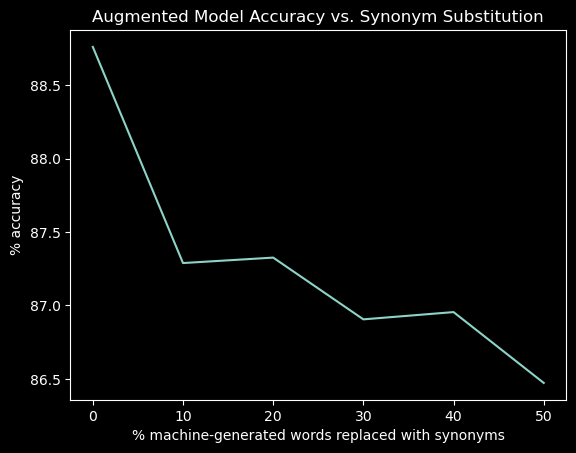

In [50]:
plt.plot(np.array(pcts) * 100, np.array(aug_accuracies) * 100)
plt.title("Augmented Model Accuracy vs. Synonym Substitution")
plt.xlabel("% machine-generated words replaced with synonyms")
plt.ylabel("% accuracy")

The above approach offers a revealing look into the performance of the wordnet_augmented_40pct model when tested against a series of increasingly challenging thesaurus attacks, where varying percentages of words in the reviews are substituted with their synonyms. This test simulates an adversarial environment where spammers might modify the text to evade detection mechanisms by replacing key words with synonyms, thereby potentially altering the semantic fingerprints that models are trained to detect.

Model Performance Overview:
The initial model accuracy without any synonym substitution stands at 89%. This represents the baseline performance of the model when it evaluates text that has not been altered, serving as an indicator of its effectiveness under normal conditions. As the percentage of substituted words increases, a clear trend emerges: the model’s accuracy consistently declines. With a 10% substitution, accuracy drops to 87%, and this level is more or less maintained up to a 40% substitution rate. However, upon reaching a 50% substitution rate, accuracy slightly declines further to 86%.

## Results and Evaluation <a class="anchor" id="evaluation"></a>

<p style="color:red">Results and Evaluation section. Mention SpaCy base model as Champion, but reference linguistic traditional models and adversarial exploration.</p>

## Conclusion <a class="anchor" id="conclusion"></a>

## Future Work <a class="anchor" id="future"></a>